In [43]:
# Let's first work out which parameter we're actually interested in.
from dadvi.pymc.models.potus import get_potus_model

In [44]:
potus_model = get_potus_model('../data/potus_data.json')

/home/martin/projects/pymc_v4/pymc/pymc/distributions/bound.py:186: FutureWarning: Bound has been deprecated in favor of Truncated, and will be removed in a future release. If Truncated is not an option, Bound can be implemented byadding an IntervalTransform between lower and upper to a continuous variable. A Potential that returns negative infinity for values outside of the bounds can be used for discrete variables.
  warnings.warn(


In [45]:
import numpy as np
import json

data = json.load(open('../data/potus_data.json'))

np_data = {x: np.squeeze(np.array(y)) for x, y in data.items()}

In [46]:
from dadvi.pymc.pymc_to_jax import get_jax_functions_from_pymc
from dadvi.jax import build_dadvi_funs

In [47]:
jax_funs = get_jax_functions_from_pymc(potus_model)

In [48]:
jax_funs

{'log_posterior_fun': <function dadvi.pymc.pymc_to_jax.get_jax_functions_from_pymc.<locals>.flat_log_post_fun(flat_params)>,
 'unflatten_fun': <function jax._src.flatten_util.ravel_pytree.<locals>.<lambda>(flat)>,
 'n_params': 15098}

In [49]:
import numpy as np

In [50]:
z = np.arange(jax_funs['n_params'])

In [51]:
param_dict = jax_funs['unflatten_fun'](z)

In [52]:
param_shapes = {x: y.shape for x, y in param_dict.items()}

In [53]:
param_shapes

{'mu_e_bias': (),
 'raw_e_bias': (254,),
 'raw_measure_noise_national': (361,),
 'raw_measure_noise_state': (1258,),
 'raw_mu_b': (51, 254),
 'raw_mu_b_T': (51,),
 'raw_mu_c': (161,),
 'raw_mu_m': (3,),
 'raw_mu_pop': (3,),
 'raw_polling_bias': (51,),
 'rho_e_bias_interval__': ()}

In [54]:
# Maybe I can use `raw_mu_b_T`, which is possibly the final vote share except for a known matrix multiplication:
"""
         mu_b_final = (
            pm.math.dot(cholesky_ss_cov_mu_b_T, raw_mu_b_T) + np_data["mu_b_prior"]
        )
"""
# I guess if I can get its covariance, I should be able to reconstruct things.
# So, next steps:
# 1. Work out the indices corresponding to `raw_mu_b_T`
# 2. Use CG to calculate the relevant covariances 
# 3. Am I screwed because I can only get marginal frequentist variances?
# 4. Maybe consult with Ryan

'\n         mu_b_final = (\n            pm.math.dot(cholesky_ss_cov_mu_b_T, raw_mu_b_T) + np_data["mu_b_prior"]\n        )\n'

In [55]:
indices = param_dict['raw_mu_b_T']

In [56]:
sample_index = indices[0]

In [57]:
from dadvi.core import compute_hessian_inv_column
from dadvi.core import compute_score_matrix

In [74]:
# Load the optimal parameters
import pickle
from glob import glob

all_runs = glob('/media/martin/External Drive/projects/lrvb_paper/potus_coverage_warm_starts/100_reruns/M_64/*/*.pkl')
reference = [x for x in all_runs if 'reference' in x][0]
other_runs = [x for x in all_runs if 'reference' not in x]

results = pickle.load(open(reference, 'rb'))

In [75]:
reference

'/media/martin/External Drive/projects/lrvb_paper/potus_coverage_warm_starts/100_reruns/M_64/potus/reference.pkl'

In [76]:
results

{'seed': 2,
 'opt_result': {'opt_result':      fun: 28827.468004718103
       jac: array([ 7.96841521e-06,  9.10227725e-07,  3.64085571e-07, ...,
         -8.33288833e-09, -3.74740167e-08, -2.55321952e-06])
   message: 'Optimization terminated successfully.'
      nfev: 50
      nhev: 639
       nit: 49
      njev: 45
    status: 0
   success: True
         x: DeviceArray([ 0.00865028, -0.13800604, -0.02989164, ..., -0.18470881,
               -0.03990547, -0.58674166], dtype=float64),
  'evaluation_count': {'n_hvp_calls': 638, 'n_val_and_grad_calls': 50},
  'newton_step_norm': 1.8379498497599394e-09},
 'z': array([[-0.41675785, -0.05626683, -2.1361961 , ..., -0.4487264 ,
         -0.63901784,  0.73930396],
        [-0.63975464,  2.42046345, -0.01443323, ..., -0.05534883,
         -0.33986302,  0.67970549],
        [ 0.8296469 , -1.48404724,  0.72339503, ...,  0.54433581,
          0.20032777,  0.42302363],
        ...,
        [ 0.40518906,  0.72603071,  0.77002311, ...,  0.12485098,


In [77]:
opt_params = results['opt_result']['opt_result'].x

# Store these in future -- not good:
np.random.seed(results['seed'])
z = np.random.randn(64, jax_funs['n_params'])

#z = results['fixed_draws']
dadvi_funs = build_dadvi_funs(jax_funs['log_posterior_fun'])

In [78]:
from tqdm import tqdm

In [79]:
score_mat = compute_score_matrix(opt_params, dadvi_funs.kl_est_and_grad_fun, z)

In [80]:
opt_means = opt_params[:opt_params.shape[0]//2]

In [81]:
mean_dict = jax_funs['unflatten_fun'](opt_means)

In [82]:
national_cov_matrix_error_sd = np.sqrt(
        np.squeeze(
            np_data["state_weights"].reshape(1, -1)
            @ (np_data["state_covariance_0"] @ np_data["state_weights"].reshape(-1, 1))
        )
    )
ss_cov_mu_b_T = (
    np_data["state_covariance_0"]
    * (np_data["mu_b_T_scale"] / national_cov_matrix_error_sd) ** 2
)
cholesky_ss_cov_mu_b_T = np.linalg.cholesky(ss_cov_mu_b_T)

rel_means = mean_dict['raw_mu_b_T']

In [83]:
mean_shares = cholesky_ss_cov_mu_b_T @ rel_means + np_data["mu_b_prior"]

In [84]:
national_average = mean_shares @ np_data['state_weights']

In [85]:
np_data['state_weights']

array([0.0023, 0.0158, 0.0081, 0.0183, 0.1025, 0.0207, 0.0118, 0.0024,
       0.0033, 0.0677, 0.0305, 0.0034, 0.0121, 0.0051, 0.0395, 0.02  ,
       0.0088, 0.0136, 0.0153, 0.0246, 0.0209, 0.0054, 0.0358, 0.0226,
       0.0209, 0.0097, 0.0037, 0.0353, 0.0026, 0.0061, 0.0054, 0.0278,
       0.0059, 0.0081, 0.0541, 0.0421, 0.0103, 0.014 , 0.0434, 0.0034,
       0.0154, 0.0028, 0.019 , 0.0644, 0.0081, 0.0299, 0.0023, 0.0246,
       0.0233, 0.005 , 0.0019])

In [86]:
national_average

DeviceArray(0.05704013, dtype=float64)

In [87]:
# There might be a bit more but this is a good start.
# Compute the gradient required now.

In [88]:
from jax.scipy.special import expit
from jax import grad
from dadvi.utils import cg_using_fun_scipy

# Check whether this is the correct way to get the national pct!!
def compute_final_vote_share(full_var_params):

    # I think we only need the means:
    opt_means = full_var_params[:full_var_params.shape[0] // 2]

    mean_dict = jax_funs['unflatten_fun'](opt_means)

    rel_means = mean_dict['raw_mu_b_T']

    mean_shares = cholesky_ss_cov_mu_b_T @ rel_means + np_data["mu_b_prior"]

    return expit(mean_shares) @ np_data['state_weights']

def estimate_final_vote_share_and_freq_sd(opt_params, dadvi_funs, z):
    
    final_share = compute_final_vote_share(opt_params)
    
    rel_grad = grad(compute_final_vote_share)(opt_params)
    
    # TODO Preconditioner
    rel_hvp = lambda x: dadvi_funs.kl_est_hvp_fun(opt_params, z, x)
    cg_result = cg_using_fun_scipy(rel_hvp, rel_grad, preconditioner=None)
    h_inv_g = cg_result[0]
        
    score_mat = compute_score_matrix(opt_params, dadvi_funs.kl_est_and_grad_fun, z)
    score_mat_means = score_mat.mean(axis=0, keepdims=True)
    centred_score_mat = score_mat - score_mat_means
    
    vec = centred_score_mat @ h_inv_g
    M = score_mat.shape[0]
    freq_sd = np.sqrt((vec.T @ vec) / (M * (M - 1)))
    
    return final_share, freq_sd

In [89]:
ref_vote_share, ref_sd = estimate_final_vote_share_and_freq_sd(opt_params, dadvi_funs, z)

In [90]:
# Load the runs
from glob import glob
from tqdm.notebook import tqdm

In [94]:
len(other_runs)

100

In [92]:
loaded = pickle.load(open(sorted(other_runs)[-1], 'rb'))

loaded

{'seed': 1099,
 'opt_result': {'opt_result':      fun: 28820.432971719776
       jac: array([ 6.55642225e-08, -3.72591049e-08, -4.29381676e-08, ...,
         -5.88295530e-09,  1.52820221e-09,  2.57231091e-07])
   message: 'Optimization terminated successfully.'
      nfev: 23
      nhev: 345
       nit: 22
      njev: 22
    status: 0
   success: True
         x: DeviceArray([ 0.00985286, -0.16380827,  0.07167079, ..., -0.27585303,
               -0.15189824, -0.76444146], dtype=float64),
  'evaluation_count': {'n_hvp_calls': 344, 'n_val_and_grad_calls': 23},
  'newton_step_norm': 0.0},
 'z': array([[ 2.4103017 , -1.67541134, -1.56577809, ...,  2.15826372,
          3.59656925, -1.41003573],
        [ 0.0399059 , -1.24591447, -0.74385217, ..., -1.3639813 ,
          0.18338042, -0.54648866],
        [ 0.46700162, -0.118007  ,  0.24039945, ...,  2.07852499,
          0.36156539,  0.35620881],
        ...,
        [ 0.0441793 ,  0.45885518, -0.35841257, ...,  0.91678686,
         -0.9844

In [95]:
others_loaded = [pickle.load(open(x, 'rb')) for x in other_runs]

rerun_results = list()

# Add zs retrospectively
for cur_loaded in tqdm(others_loaded[:3]):
    
    other_z = cur_loaded['z']
    new_opt_params = cur_loaded['opt_result']['opt_result'].x
    vote_share, sd = estimate_final_vote_share_and_freq_sd(new_opt_params, dadvi_funs, other_z)
   
    rerun_results.append({'vote_share': vote_share, 'sd': sd})
    
    break

  0%|          | 0/3 [00:00<?, ?it/s]

In [17]:
pd.DataFrame(rerun_results).to_csv('rerun_sds.csv')

NameError: name 'pd' is not defined

In [59]:
all_zs = list()

for other_run in others_loaded:

    other_opt_params = other_run['opt_result']['opt_result'].x

    other_res = compute_final_vote_share(other_opt_params)
    prev_res = compute_final_vote_share(opt_params)

    cur_z = (other_res - prev_res) / (np.sqrt(2) * freq_sd)

    all_zs.append(cur_z)

(array([ 2.,  7., 11., 10., 16., 16.,  8., 14.,  7.,  9.]),
 array([0.03355775, 0.12331   , 0.21306224, 0.30281449, 0.39256674,
        0.48231898, 0.57207123, 0.66182348, 0.75157572, 0.84132797,
        0.93108021]),
 <BarContainer object of 10 artists>)

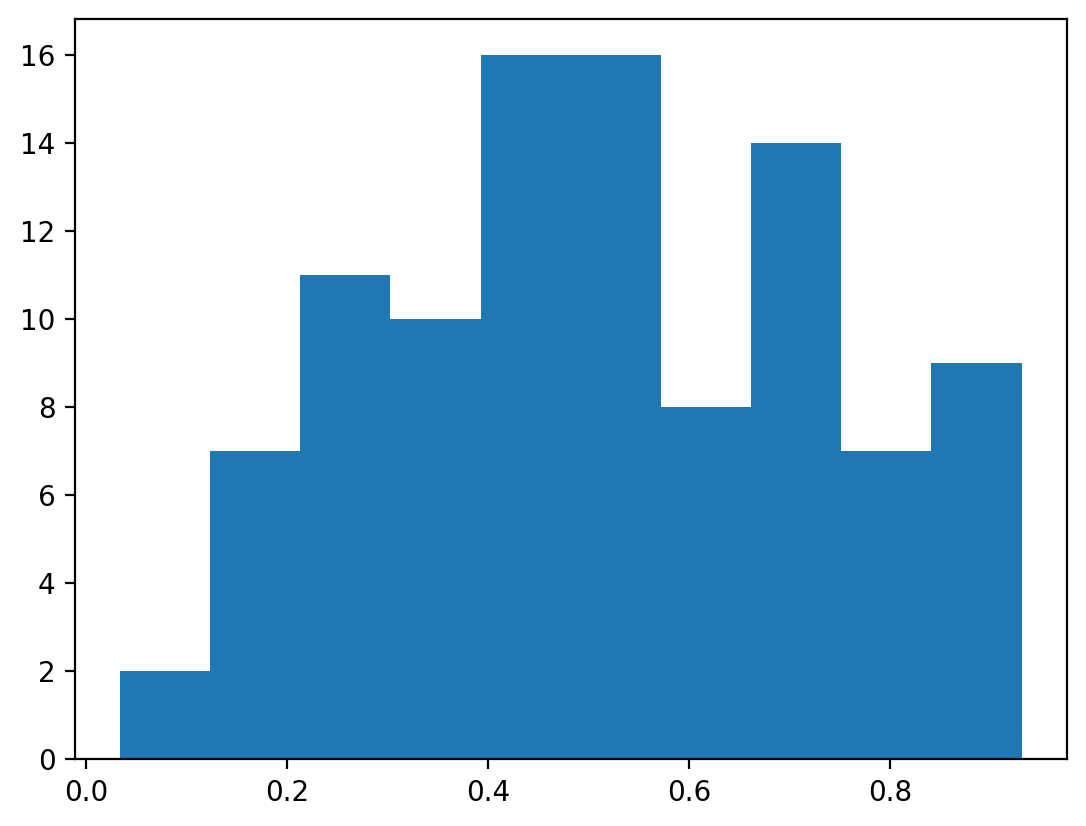

In [67]:
import matplotlib.pyplot as plt
from scipy.stats import norm

plt.hist(norm.cdf(np.array(all_zs)))

In [61]:
# What do they look like marginally over all of them
# Check pairs more systematically
# If not good, check better score matrix.
# Warm starts for this as well
compute_final_vote_share(opt_params)

DeviceArray(0.51361712, dtype=float64)

In [62]:
freq_sd

0.0002844109770952017